

*   Nama Peserta : Nalom Maruli Tua
*   Panggilan : Nalom
*   Class Dicoding : Belajar Pengembangan Machine Learning
*   Tgl Selesai : 8 Agustus 2021
*   Email : siregarnalom@gmail.com



In [105]:
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split  
# For Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-08-08 15:05:04--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.213.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2021-08-08 15:05:04 (217 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [107]:
vocab_size = 5000 
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'x' 
training_portion = .8

In [108]:
articles = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

In [109]:
train_size = int(len(articles) * training_portion)

kalimat_train = articles[0: train_size]
kategori_train = labels[0: train_size]

kalimat_val = articles[train_size:]
kategori_val = labels[train_size:]

In [110]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(kalimat_train)
tokenizer.fit_on_texts(kalimat_val)

sequence_train = tokenizer.texts_to_sequences(kalimat_train)
sequence_val = tokenizer.texts_to_sequences(kalimat_val)

padd_train = pad_sequences(sequence_train, padding=padding_type, truncating=trunc_type)
padd_val = pad_sequences(sequence_val, padding=padding_type, truncating=trunc_type)


In [111]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

kategori_train_seq = np.array(label_tokenizer.texts_to_sequences(kategori_train))
kategori_val_seq = np.array(label_tokenizer.texts_to_sequences(kategori_val))

In [112]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          320000    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 774       
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


In [113]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

In [114]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9 and logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [115]:
num_epochs = 10
history = model.fit(padd_train, kategori_train_seq, epochs=num_epochs, callbacks=[callbacks], 
                    validation_data=(padd_val, kategori_val_seq), verbose=2)



Epoch 1/10
56/56 - 162s - loss: 1.6210 - accuracy: 0.2691 - val_loss: 1.4681 - val_accuracy: 0.4584
Epoch 2/10
56/56 - 158s - loss: 0.9599 - accuracy: 0.7028 - val_loss: 0.7293 - val_accuracy: 0.8404
Epoch 3/10
56/56 - 158s - loss: 0.4131 - accuracy: 0.8893 - val_loss: 0.4047 - val_accuracy: 0.9101
Epoch 4/10
56/56 - 159s - loss: 0.3413 - accuracy: 0.9275 - val_loss: 0.3498 - val_accuracy: 0.9191

Akurasi telah mencapai >90%!


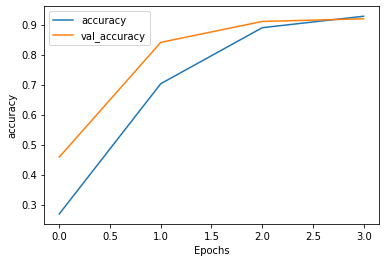

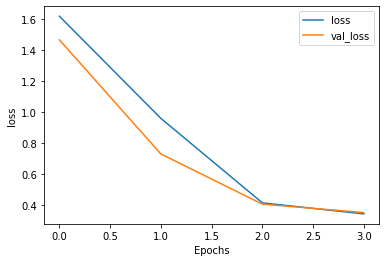

In [116]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")